# MSDS 7331 Data Mining Lab 3
Professor: Dr. Jake Drew  
Team: Steven Hayden, Josephine MacDaniel, Korey MacVittie, Afreen Siddiqui, Eduardo Cantu

In [1]:
#load Libraries
import pandas as pd
import numpy as np
import seaborn as seaborn
import matplotlib.pyplot as plt
import matplotlib as mp1
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.basemap import Basemap

In [2]:
#Load Data
Accident_df_2016 = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/accident_2016.csv',low_memory=False)
Accident_df_2015 = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/accident_2015.csv',low_memory=False)
Accident_df = pd.concat([Accident_df_2015,Accident_df_2016])


#Load Damage Data
Distract_df = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/distract.csv',low_memory=False)
Damage_df = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/damage.csv',low_memory=False)

#Merge the distract data and damage data
Accident_df = Accident_df.merge(Distract_df,left_on = 'consecutive_number', right_on = 'consecutive_number', how= 'left')
Accident_df = Accident_df.merge(Damage_df,left_on = 'consecutive_number', right_on = 'consecutive_number', how= 'left')


## Data Meaning Type
In this section, we will go over the attributes in our data set, and explain each. These descriptions are taken from the kaggle site for this data, found [here](https://www.kaggle.com/usdot/nhtsa-traffic-fatalities).

There are quite a few variables here - however, many of them are redundant with each other. As should not be surprising when governmental bureaucracy is involved, there are a variety of variables here that are "encoded" and redundant with one another. Much of the information relates to the location of the accident: latitude, longitude, type of roadway, nearest mile marker, type of intersection, and so forth.

| Variable Name | Data Type | Description |
| :- | :- | :- |
| state_number | Interval | Identifies the state in which the crash occurred. The codes are from the General Services Administration’s (GSA) publication of worldwide Geographic Location Codes (GLC). For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| state_name | Nominal | Identifies the state in which the crash occurred. The codes are from the General Services Administration’s (GSA) publication of worldwide Geographic Location Codes (GLC). |
| consecutive_number | Interval | Unique case number assigned to each crash. It appears on each data file and is used to merge information from the data files together. xxxxxx Two Characters for State Code followed by Four Characters for Case Number. |
| number_of_vehicle_forms_submitted_all | Interval | Count of the total number of vehicles involved. |
| number_of_motor_vehicles_in_transport_mvit | Interval | Count of the number of vehicles in-transport involved in the crash. Legally parked vehicles are not included. |
| number_of_parked_working_vehicles | Interval | Count of the number of parked and working vehicles involved in the crash. |
| number_of_forms_submitted_for_persons_not_in_motor_vehicles | Interval | Number of Person Forms (Not a Motor Vehicle Occupant) that are applicable to this case (i.e., non-occupants). |
| number_of_persons_not_in_motor_vehicles_in_transport_mvit | Interval | Count of the number of non-motorists in the crash. A non-motorist is defined as a pedestrian, a cyclist, an occupant of a motor vehicle not intransport, a person riding a horse, an occupant of an animal drawn conveyance, person associated with non-motorist conveyance (e.g., baby carriage, skate board, wheelchair), or an other non-motorist (e.g., person outside a trafficway, person in a house). |
| number_of_persons_in_motor_vehicles_in_transport_mvit | Interval | Count of the number of motorists in the crash. A motorist is a driver, passenger or unknown occupant type of a motor vehicle in-transport. |
| number_of_forms_submitted_for_persons_in_motor_vehicles | Interval | Count of the number of Person Level (Motor Vehicle Occupant) Forms that are applicable to this case (i.e., occupants). |
| county | Nominal | Records the location of the unstabilized event with regard to the County. The codes are from the General Services Administration’s (GSA) publication of worldwide Geographic Location Codes (GLC). |
| city | Nominal | Records the location of the unstabilized event with regard to the City. The codes are from the General Services Administration’s (GSA) publication of worldwide Geographic Location Codes (GLC). |
| day_of_crash | Ordinal | Records the day of the month on which the crash occurred. |
| month_of_crash | Ordinal | Records the month in which the crash occurred. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| year_of_crash | Ordinal | Records the year in which the crash occurred. |
| day_of_week | Ordinal | Records the day of the week on which the crash occurred. Sunday is Day 1. |
| hour_of_crash | Ordinal | Records the hour at which the crash occurred. Listed in 24-hour format. |
| minute_of_crash | Ordinal | Records the minutes after the hour at which the crash occurred. |
| national_highway_system | Nominal | Identifies whether this crash occurred on a trafficway that is part of the National Highway System. |
| land_use | Nominal | 1 (Rural), 2 (Urban), 6 (Trafficway Not in State Inventory), 8 (Not Reported) and 9 (Unknown). |
| land_use_name | Nominal | 1 (Rural), 2 (Urban), 6 (Trafficway Not in State Inventory), 8 (Not Reported) and 9 (Unknown). |
| functional_system | Nominal | 01 (Interstate), 02 (Principal Arterial – Other Freeways and Expressways), 03 (Principal Arterial – Other), 04 (Minor Arterial), 05 (Major Collector), 06 (Minor Collector), 07 (Local), 96 (Trafficway Not in State Inventory), 98 (Not Reported), and 99 (Unknown). |
| functional_system_name | Nominal | 01 (Interstate), 02 (Principal Arterial – Other Freeways and Expressways), 03 (Principal Arterial – Other), 04 (Minor Arterial), 05 (Major Collector), 06 (Minor Collector), 07 (Local), 96 (Trafficway Not in State Inventory), 98 (Not Reported), and 99 (Unknown). |
| ownership | Nominal | For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| ownership_name | Nominal | For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| route_signing | Nominal | Identifies the route signing of the trafficway on which the crash occurred, using a coding system. |
| route_signing_name | Nominal | Identifies the route signing of the trafficway on which the crash occurred. |
| trafficway_identifier | Nominal | Records the trafficway on which the crash occurred. |
| trafficway_identifier_2 | Nominal | Records the trafficway on which the crash occurred. |
| milepoint | Interval | Records the milepoint nearest to the location where the crash occurred, if applicable.
| latitude | Interval | Identifies the location of the crash using Global Position coordinates. This is the position of latitude. |
| longitude | Interval | Identifies the location of the crash using Global Position coordinates. |
| special_jurisdiction | Nominal | Identifies if the location on the trafficway where the crash occurred qualifies as a Special Jurisdiction even though it may be patrolled by state, county or local police (e.g., all State highways running through Indian reservations are under the jurisdiction of the Indian reservation). |
| special_jurisdiction_name | Nominal | Identifies if the location on the trafficway where the crash occurred qualifies as a Special Jurisdiction even though it may be patrolled by state, county or local police (e.g., all State highways running through Indian reservations are under the jurisdiction of the Indian reservation). |
| first_harmful_event | Nominal | Describes the first injury or damage producing event of the crash. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| first_harmful_event_name | Nominal | Describes the first injury or damage producing event of the crash. |
| manner_of_collision | Nominal | Describes the orientation of two motor vehicles in-transport when they are involved in the “First Harmful Event” of a collision crash. If the “First Harmful Event” is not a collision between two motor vehicles in-transport it is classified as such. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| manner_of_collision_name | Nominal | Describes the orientation of two motor vehicles in-transport when they are involved in the “First Harmful Event” of a collision crash. If the “First Harmful Event” is not a collision between two motor vehicles in-transport it is classified as such. |
| relation_to_junction_within_interchange_area | Nominal | Identifies the crash's location with respect to presence in an interchange area. The coding of this data element is done in two sub-fields (see also C20B) and is based on the location of the “First Harmful Event” of the crash. (0) No (1) Yes (8) Not Reported (9) Unknown |
| relation_to_junction_specific_location | Nominal | Identifies the crash's location with respect to presence in or proximity to components typically in junction or interchange areas. The coding of this data element is done in two sub-fields (see also C20A) and is based on the location of the “First Harmful Event” of the crash. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| relation_to_junction_specific_location_name | Nominal | Identifies the crash's location with respect to presence in or proximity to components typically in junction or interchange areas. The coding of this data element is done in two sub-fields (see also C20A) and is based on the location of the “First Harmful Event” of the crash. |
| type_of_intersection | Nominal | Identifies and allows separation of various intersection types. (1) Not an Intersection (2) Four-Way Intersection (3) T-Intersection (4) Y-Intersection (5) Traffic Circle (6) Roundabout (7) Five-Point, or More (10) L-Intersection (98) Not Reported (99) Unknown |
| work_zone | Nominal | Identifies a motor vehicle traffic crash in which the first harmful event occurs within the boundaries of a work zone or on an approach to or exit from a work zone, resulting from an activity, behavior, or control related to the movement of the traffic units through the work zone. (0) None (1) Construction (2) Maintenance -- Construction or Maintenance (3) Utility (4) Work Zone, Type Unknown (--) Not Reported |
| relation_to_trafficway | Nominal | Identifies the location of the crash as it relates to its position within or outside the trafficway based on the “First Harmful Event.” For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| relation_to_trafficway_name | Nominal | Identifies the location of the crash as it relates to its position within or outside the trafficway based on the “First Harmful Event.” |
| light_condition | Nominal | Records the type/level of light that existed at the time of the crash as indicated in the case material. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| light_condition_name | Nominal | Records the type/level of light that existed at the time of the crash as indicated in the case material. |
| atmospheric_conditions_1 | Nominal | Records the prevailing atmospheric conditions that existed at the time of the crash as indicated in the case material. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| atmospheric_conditions_1_name | Nominal | Records the prevailing atmospheric conditions that existed at the time of the crash as indicated in the case material. |
| atmospheric_conditions_2 | Nominal | Records the prevailing atmospheric conditions that existed at the time of the crash as indicated in the case material. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| atmospheric_conditions_2_name | Nominal | Records the prevailing atmospheric conditions that existed at the time of the crash as indicated in the case material. |
| atmospheric_conditions | Nominal | Records the prevailing atmospheric conditions that existed at the time of the crash as indicated in the case material. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| atmospheric_conditions_name | Nominal | Records the prevailing atmospheric conditions that existed at the time of the crash as indicated in the case material. |
| school_bus_related | Nominal | Identifies if a school bus, or motor vehicle functioning as a school bus, is related to the crash. (0) No (1) Yes (--) Not Reported |
| rail_grade_crossing_identifier | Nominal | Identifies if the crash occurred in or near a rail grade crossing. |
| hour_of_notification | Interval | Records the hour that emergency medical service was notified, in 24-hour format. |
| minute_of_notification | Interval | Records the minutes after the hour that emergency medical service was notified. |
| hour_of_arrival_at_scene | Interval | Records the hour that emergency medical service arrived on the crash scene, in 24-hour format. |
| minute_of_arrival_at_scene | Interval | Records the minutes after the hour that emergency medical service arrived on the crash scene. |
| hour_of_ems_arrival_at_hospital | Interval | Records the hour that emergency medical service arrived at the treatment facility to which it was transporting victims of the crash, in 24-hour format. |
| minute_of_ems_arrival_at_hospital | Interval | Records the minutes after the hour that emergency medical service arrived at the treatment facility to which it was transporting victims of the crash. |
| related_factors_crash_level_1 | Nominal | Records factors related to the crash expressed by the investigating officer. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| related_factors_crash_level_1_name | Nominal | Records factors related to the crash expressed by the investigating officer. |
| related_factors_crash_level_2 | Nominal | Records factors related to the crash expressed by the investigating officer. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| related_factors_crash_level_2_name | Nominal | Records factors related to the crash expressed by the investigating officer. |
| related_factors_crash_level_3 | Nominal | Records factors related to the crash expressed by the investigating officer. For more info on the codes, please look at section in the pdf: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 |
| related_factors_crash_level_3_name | Nominal | Records factors related to the crash expressed by the investigating officer. |
| number_of_fatalities | Interval | Records the number of fatally injured persons in the crash. |
| number_of_drunk_drivers | Interval | Records the number of drunk drivers involved in the crash. |
| timestamp_of_crash | Nominal | This data element records the date and time on which the crash occurred. |
| Clock points | Nominal | Records the count of damage points on the side of the vehicles. |
| No Damage | Nominal | Records the count of vehicles with no damage. |
| Top | Nominal | Records the count of vehicles with damage on the roof. |
| Undercarriage | Nominal | Records the count of vehicles with damage on the undercarriage. |
| Unknown | Nominal | Records the count of vehicles with unknow damage on. |
| By a Moving Object in Vehicle | Nominal | Count of drivers that were distracted by a moving object in the vehicle. |
| By Other Occupant(s) | Nominal | Count of drivers that were distracted by other occupant(s). |
| Careless/Inattentive | Nominal | Count of drivers that were careless or inattentive. |
| Distracted by Outside Person, Object or Event | Nominal | Count of drivers that were distracted by outside Person, Object or Event |
| Distraction (Distracted), Details Unknown | Nominal | Count of drivers that were distracted by a unknown reason. |
| Distraction/Inattention | Nominal | Count of drivers that were inattentive. |
| Eating or Drinking | Nominal | Count of drivers that were eating or drinking. |
| Inattention (Inattentive), Details Unknown | Nominal | count of drivers that were inattentive with unkown details. |
| Looked But Did Not See | Nominal | Count of drivers that looked but did not see. |
| Lost In Thought/Day Dreaming | Nominal | Count of drivers that lost in thought/day dreaming. |
| No Driver Present/Unknown if Driver Present | Nominal | Count of vehicles unknows if driver was present. |
| Not Distracted | Nominal | Count of drivers that were not distracted. |
| Not Reported | Nominal | Count of vehicles that did not have a distraction reported. |
| Other Cellular Phone Related | Nominal | Count of drivers that were distracted related to a cell phone. |
| Other Distraction | Nominal | Count of drivers that were distracted due to other circumstances. |
| Smoking Related | Nominal | Count of drivers that were distracted due to smoking. |
| Unknown if Distracted | Nominal | Count of drivers that were unknow if they were distracted. |
| While Adjusting Audio or Climate Controls | Nominal | Count of drivers that were distracted adjusting audio or climate controls. |
| While Manipulating Cellular Phone | Nominal | Count of drivers that were distracted manipulating a cell phone. |
| While Talking or Listening to Cellular Phone | Nominal | Count of drivers that were distracted due Talking/Listening to a cell phone. |
| While Using or Reaching For Device/Object Brought Into Vehicle | Nominal | Count of drivers that were distracted due to using or reaching for device/object. |
| While Using Other Component/Controls Integral to Vehicle | Nominal | Count of drivers that were distracted due to using other component/controls integral to vehicle. |

In [3]:
# Displays the record count of non-null Values per attribute and their data type. 
Accident_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66978 entries, 0 to 66977
Data columns (total 99 columns):
Unnamed: 0                                                        66978 non-null int64
state_number                                                      66978 non-null int64
state_name                                                        66978 non-null object
consecutive_number                                                66978 non-null int64
number_of_vehicle_forms_submitted_all                             66978 non-null int64
number_of_motor_vehicles_in_transport_mvit                        66978 non-null int64
number_of_parked_working_vehicles                                 66978 non-null int64
number_of_forms_submitted_for_persons_not_in_motor_vehicles       66978 non-null int64
number_of_persons_not_in_motor_vehicles_in_transport_mvit         66978 non-null int64
number_of_persons_in_motor_vehicles_in_transport_mvit             66978 non-null int64
number_of_forms_subm

**Duplicate Removal**

In [4]:
#Print shape before duplicate removal
print("Data Shape before duplicate Removal:", Accident_df.shape)

Data Shape before duplicate Removal: (66978, 99)


In [5]:
#check for duplicate records. It displays the maximum count of a duplicated record. 
#Any value greater than 1 would mean that the data has duplicates
Accident_df['consecutive_number'].value_counts().max()

2

In [6]:
#Drop duplicate records and keeps the most recent record. We assume the most resent is the most accurate 
Accident_df = Accident_df.drop_duplicates(['consecutive_number'],keep = 'last')

#check for duplicate records. It displays the maximum count of a duplicated record . 
#Any value greater than 1 would mean that the data has duplicates
Accident_df['consecutive_number'].value_counts().max()

1

In [7]:
#Print shape After duplicate removal
print("Data Shape After duplicate Removal:", Accident_df.shape)

Data Shape After duplicate Removal: (35379, 99)


In [8]:
#Displays all the available attributes on the dataset
Accident_df=Accident_df.reset_index()
Accident_df.count()

index                                                             35379
Unnamed: 0                                                        35379
state_number                                                      35379
state_name                                                        35379
consecutive_number                                                35379
number_of_vehicle_forms_submitted_all                             35379
number_of_motor_vehicles_in_transport_mvit                        35379
number_of_parked_working_vehicles                                 35379
number_of_forms_submitted_for_persons_not_in_motor_vehicles       35379
number_of_persons_not_in_motor_vehicles_in_transport_mvit         35379
number_of_persons_in_motor_vehicles_in_transport_mvit             35379
number_of_forms_submitted_for_persons_in_motor_vehicles           35379
county                                                            35379
city                                                            

#### Data Type Colunm Count
This will look into the number of attributes per variable type

In [9]:
# Take a look a at the data type on the Merged Data
dtype_df=Accident_df.dtypes.reset_index()
dtype_df.columns=["Count","ColumnType"]
dtype_df.groupby("ColumnType").aggregate('count').reset_index()

,ColumnType,Count
0,int64,45
1,float64,30
2,object,25


#### Description of the Categorical Variables

In [10]:
# Describe the Categorical Objects
list_include = ['object']
Accident_df.describe(include=list_include).T

,count,unique,top,freq
state_name,35379,51,Texas,3495
land_use_name,35379,5,Rural,17181
functional_system_name,35379,10,Principal Arterial – Other,10396
ownership_name,35379,25,State Highway Agency,18486
route_signing_name,35379,9,State Highway,10498
trafficway_identifier,35379,16928,I-10,312
trafficway_identifier_2,9432,8138,MAIN ST,26
special_jurisdiction_name,35379,7,No Special Jurisdiction (Includes National For...,34974
first_harmful_event_name,35379,51,Motor Vehicle in Transport,13432
manner_of_collision_name,35379,11,Not Collision with Motor Vehicle in Transport ...,21900


In [ ]:
####Do not Run- Long run time




#Frequency Histograms for the unbalanced attributes
#for col in ['school_bus_related','special_jurisdiction_name','special_jurisdiction_name','relation_to_junction_within_interchange_area',
#           'work_zone','atmospheric_conditions_2_name','rail_grade_crossing_identifier','related_factors_crash_level_1_name','related_factors_crash_level_2_name',
#           'related_factors_crash_level_3_name']:

from matplotlib.ticker import NullFormatter  # useful for `logit` scale
list_include = ['object']
i=1
for col in Accident_df.select_dtypes(include=list_include).columns:
    if col not in ['trafficway_identifier','trafficway_identifier_2','timestamp_of_crash']:
        if i<=3:
            #plt.figure(figsize=(10,4))
            plt.subplot(1,3,i)
            plt.hist(Accident_df[col], bins=len(Accident_df[col].unique()))
            plt.title(col,size=7.8)
            plt.xlabel('Class', size=5)
            plt.ylabel('Class frequency', size=7)
            plt.xticks(rotation='vertical', size=4)
            plt.yticks(size=7)
            i=i+1
        else:
            plt.subplots_adjust(top=.7, bottom=0.4, left=0.01, right=1.1, hspace=0.25, wspace=2)
            plt.show()
            i = 1

plt.subplots_adjust(top=.7, bottom=0.4, left=0.01, right=1.1, hspace=0.25, wspace=2)
plt.show()



There are attritbutes that show extreme imbalance in the dataset. These attributes do not add value to the prediction since most the values are the same. Also, when doing cross validation there is a high probaility that the test set only chooses the highest class.

**Imbalance Attributes:**  
* school_bus_related  
* special_jurisdiction_name
* relation_to_junction_within_interchange_area
* work_zone
* atmospheric_conditions_1_name
* atmospheric_conditions_2_name
* rail_grade_crossing_identifier
* related_factors_crash_level_1_name
* related_factors_crash_level_2_name
* related_factors_crash_level_3_name
* trafficway_identifier
* trafficway_identifier_2

#### Description of the Float Variables

In [11]:
# Describe the Float Objects
list_include = ['float64']
Accident_df.describe(include=list_include).T

,count,mean,std,min,25%,50%,75%,max
latitude,35379.0,36.925757,7.203311,19.101319,32.994856,36.287044,40.610408,99.9999
longitude,35379.0,-85.298045,87.623932,-174.204181,-97.902897,-87.767303,-81.459606,999.9999
By a Moving Object in Vehicle,35364.0,0.000339,0.018418,0.000000,0.000000,0.000000,0.000000,1.0000
By Other Occupant(s),35364.0,0.005033,0.071167,0.000000,0.000000,0.000000,0.000000,2.0000
Careless/Inattentive,35364.0,0.001414,0.037575,0.000000,0.000000,0.000000,0.000000,1.0000
"Distracted by Outside Person, Object or Event",35364.0,0.006080,0.084699,0.000000,0.000000,0.000000,0.000000,6.0000
"Distraction (Distracted), Details Unknown",35364.0,0.007748,0.089280,0.000000,0.000000,0.000000,0.000000,2.0000
Distraction/Careless,35364.0,0.000198,0.014068,0.000000,0.000000,0.000000,0.000000,1.0000
Distraction/Inattention,35364.0,0.012470,0.111988,0.000000,0.000000,0.000000,0.000000,2.0000
Eating or Drinking,35364.0,0.001414,0.037575,0.000000,0.000000,0.000000,0.000000,1.0000


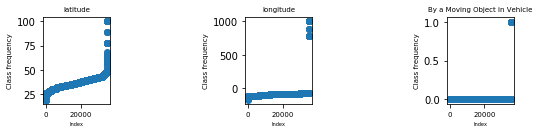

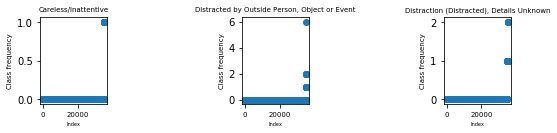

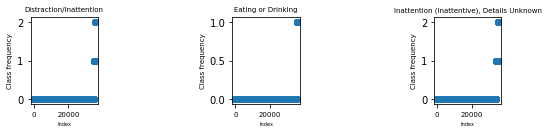

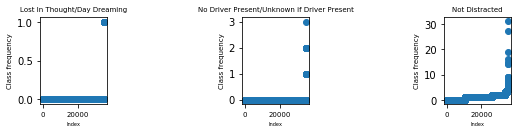

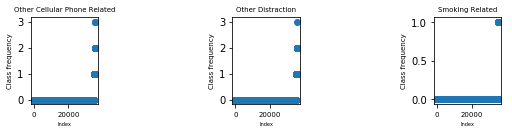

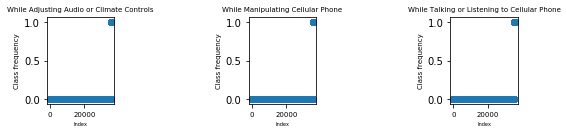

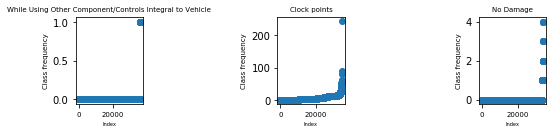

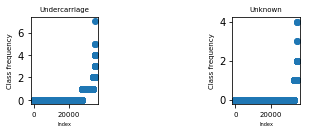

In [12]:
# Verify all float values
list_include = ['float64']
i=1
for col in Accident_df.select_dtypes(include=list_include).columns:
    if i<=3:
        #plt.figure(figsize=(10,4))
        plt.subplot(1,3,i)
        plt.scatter(range(Accident_df.shape[0]),np.sort(Accident_df[col].values))
        plt.xlabel('Index', size=5)
        plt.title(col, size=7)
        plt.ylabel('Class frequency', size=7)
        plt.xticks(size=7)
        i = i + 1
    else:
        plt.subplots_adjust(top=.7, bottom=0.4, left=0.01, right=1.1, hspace=0.25, wspace=2)
        plt.show()
        i = 1
plt.subplots_adjust(top=.7, bottom=0.4, left=0.01, right=1.1, hspace=0.25, wspace=2)
plt.show()   

**Binary classes in Float:**
* By a Moving Object in Vehicle
* By Other Occupant(s)	
* Careless/Inattentive
* Distraction/Careless
* Eating or Drinking
* Lost In Thought/Day Dreaming
* Smoking Related
* While Adjusting Audio or Climate Controls
* While Manipulating Cellular Phone
* While Talking or Listening to Cellular Phone
* While Using or Reaching For Device/Object Brought Into Vehicle
* While Using Other Component/Controls Integral to Vehicle

**Float Classes that can be integers**
* Distracted by Outside Person, Object or Event
* Distraction (Distracted), Details Unknown
* Distraction/Inattention
* Inattention (Inattentive), Details Unknown
* Looked But Did Not See 
* No Driver Present/Unknown if Driver Present
* Not Distracted
* Not Reported
* Other Cellular Phone Related
* Other Distraction
* Unknown if Distracted	
* Clock points
* No Damage
* Top
* Undercarriage
* Unknown

The only true float class is the **Fatalities_ratio, latitude, and longitude**, all other classes can be converted to integer.

#### Missing Values Per Column

In [13]:
# Missing Values
missing_df=Accident_df.isnull().sum(axis=0).reset_index()
missing_df.columns=['ColumnName','MissingCount']
missing_df=missing_df.ix[missing_df['MissingCount']>0]
missing_df=missing_df.sort_values(by='MissingCount')

missing_df = missing_df.merge(dtype_df,left_on = 'ColumnName', right_on = 'Count', how= 'left')
missing_df

C:\Users\shayden\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


,ColumnName,MissingCount,Count,ColumnType
0,Not Reported,15,Not Reported,float64
1,While Using or Reaching For Device/Object Brou...,15,While Using or Reaching For Device/Object Brou...,float64
2,While Talking or Listening to Cellular Phone,15,While Talking or Listening to Cellular Phone,float64
3,While Manipulating Cellular Phone,15,While Manipulating Cellular Phone,float64
4,While Adjusting Audio or Climate Controls,15,While Adjusting Audio or Climate Controls,float64
5,Unknown if Distracted,15,Unknown if Distracted,float64
6,Smoking Related,15,Smoking Related,float64
7,Other Distraction,15,Other Distraction,float64
8,Other Cellular Phone Related,15,Other Cellular Phone Related,float64
9,Not Distracted,15,Not Distracted,float64


In [14]:
list_include = ['float64']
# Add a 99 to all float missing values. 99 would mean that it was NA before. This has to be done in order to change the data type to integer.
# There is still a need to know what to do with these observations.
for col in Accident_df.select_dtypes(include=list_include).columns:
    if col not in ['Fatalities_ratio']:
        Accident_df[col].fillna(value=99, inplace=True)

Review Missing Values after adding value '99' to all the missing values in the above attributes. As expected only the Traffic_indentifier_2 still show 12,111 null values. Therefore, this attribute would be removed.

In [15]:
# Review missing Values Again.
# Missing Values
missing_df=Accident_df.isnull().sum(axis=0).reset_index()
missing_df.columns=['ColumnName','MissingCount']
missing_df=missing_df.ix[missing_df['MissingCount']>0]
missing_df=missing_df.sort_values(by='MissingCount')

missing_df = missing_df.merge(dtype_df,left_on = 'ColumnName', right_on = 'Count', how= 'left')
missing_df

C:\Users\shayden\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


,ColumnName,MissingCount,Count,ColumnType
0,trafficway_identifier_2,25947,trafficway_identifier_2,object


In [16]:
list_include = ['float64']
# Convert all floats into integers except for 'Fatalities_ratio'
for col in Accident_df.select_dtypes(include=list_include).columns:
    if col not in ['Fatalities_ratio','latitude','longitude']:
        Accident_df[col] = Accident_df[col].astype(int)


Check for the datatype again.

In [17]:
# Take a look a at the data type on the Merged Data
dtype_df=Accident_df.dtypes.reset_index()
dtype_df.columns=["Count","ColumnType"]
dtype_df.groupby("ColumnType").aggregate('count').reset_index()

,ColumnType,Count
0,int32,28
1,int64,45
2,float64,2
3,object,25


Remove observations that were recoreded as missing in the longitude and latitude
https://www.kaggle.com/usdot/nhtsa-traffic-fatalities

"This is the position of longitude. DDDDDDD (DDD.DDDD – Decimal Degrees) DDD.DDDD Actual Degrees 777.7777 Not Reported 888.8888 Not Available (If State Exempt) 999.9999 Unknown"

In [18]:
#Create a list to remove desired observations 
Obs_to_remove=[777.7777,888.8888,999.9999]

#remove observations
Accident_df1= Accident_df[~Accident_df['longitude'].isin(Obs_to_remove)]

#### Description of the Integer Values

In [19]:
# Describe the Integer Objects
list_include = ['int64','int32']
Accident_df.describe(include=list_include).T

,count,mean,std,min,25%,50%,75%,max
index,35379.0,48869.173945,11292.594130,172.0,40443.5,49288.0,58132.5,66977.0
Unnamed: 0,35379.0,17194.716753,9929.734295,0.0,8640.5,17139.0,25821.5,34438.0
state_number,35379.0,27.167444,16.286271,1.0,12.0,26.0,42.0,56.0
consecutive_number,35379.0,272431.865005,162771.960673,10001.0,122057.5,260922.0,420357.5,560130.0
number_of_vehicle_forms_submitted_all,35379.0,1.555273,0.851496,1.0,1.0,1.0,2.0,64.0
number_of_motor_vehicles_in_transport_mvit,35379.0,1.515588,0.808335,1.0,1.0,1.0,2.0,64.0
number_of_parked_working_vehicles,35379.0,0.039685,0.297932,0.0,0.0,0.0,0.0,11.0
number_of_forms_submitted_for_persons_not_in_motor_vehicles,35379.0,0.219339,0.471529,0.0,0.0,0.0,0.0,11.0
number_of_persons_not_in_motor_vehicles_in_transport_mvit,35379.0,0.229486,0.498395,0.0,0.0,0.0,0.0,11.0
number_of_persons_in_motor_vehicles_in_transport_mvit,35379.0,2.253399,1.884335,0.0,1.0,2.0,3.0,120.0


In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


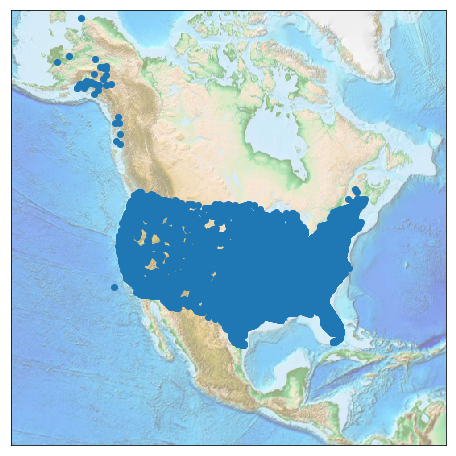

In [59]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution=None,
            width=8E6, height=8E6, 
            lat_0=45, lon_0=-100,)
m.etopo(scale=0.5, alpha=0.5)

# Map (long, lat) to (x, y) for plotting
x, y = m(Accident_df1.longitude.tolist(), Accident_df1.latitude.tolist())
m.scatter(x, y)

#plt.plot(x,y, 'ok', markersize=5)
#plt.plot(Accident_df1.longitude, Accident_df1.latitude, 'ok', markersize=5)
#plt.text(x, y, ' Seattle', fontsize=12);

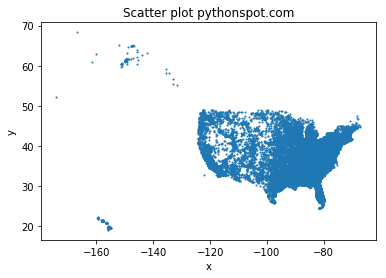

In [23]:
# Plot
plt.scatter( Accident_df1.longitude,Accident_df1.latitude, s= 1, alpha=1)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()